In [4]:
import arviz as az
import pandas as pd
import json

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('~/.matplotlib/custom.mplstyle')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *

sys.path.insert(0, '../param_est/')
from sampling_utils import *

rng = np.random.default_rng(seed=1234)

In [5]:
def load_smc_samples_to_idata(samples_json):
    """ Load SMC samples from json file to arviz InferenceData object """
    with open(samples_json, 'r') as f:
        data = json.load(f)
    
    # create idata object from dictionary
    # ignore sample stats because that changes with each SMC chain
    idata = az.from_dict(
        posterior =  data['posterior'],
        posterior_attrs = data['posterior_attrs'],
        # sample_stats = data['sample_stats'],
        observed_data = data['observed_data'],
        observed_data_attrs = data['observed_data_attrs'],
        log_likelihood = data['log_likelihood'],
        log_likelihood_attrs = data['log_likelihood_attrs'],
        constant_data = data['constant_data'],
        constant_data_attrs = data['constant_data_attrs'],
        attrs = data['attrs'],
    )

    sample_stats = data['sample_stats']

    return idata, sample_stats

# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/hatakeyama_2003_smc_samples.json')
HK_2003_post = np.load('../../../results/MAPK/param_est/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
# H_2005_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/hornberg_2005_smc_samples.json') # TODO: add once smc is done
# H_2005_post = np.load('../../../results/MAPK/param_est/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
# B_2007_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/birtwistle_2007_smc_samples.json')
# B_2007_post = np.load('../../../results/MAPK/param_est/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/orton_2009_smc_samples.json') # TODO: add once smc is done
O_2009_post = np.load('../../../results/MAPK/param_est/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
# vK_2009_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/von_kreigsheim_2009_smc_samples.json') # TODO: add once smc is done
# vK_2009_post = np.load('../../../results/MAPK/param_est/von_kreigsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/ryu_2015_smc_samples.json') # TODO: add once smc is done
R_2015_post = np.load('../../../results/MAPK/param_est/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/kochanczyk_2017_smc_samples.json') # TODO: add once smc is done
K_2017_post = np.load('../../../results/MAPK/param_est/kochanczyk_2017_posterior_predictive_samples.npy')

# Log marginal likelihoods
S_2014_log_magr = np.mean([chain[-1] for chain in S_2014_ss['log_marginal_likelihood'][0]])
HK_2003_log_magr = np.mean([chain[-1] for chain in HK_2003_ss['log_marginal_likelihood']])
K_2000_log_magr = np.mean([chain[-1] for chain in K_2000_ss['log_marginal_likelihood'][0]])
O_2009_log_magr = np.mean([chain[-1] for chain in O_2009_ss['log_marginal_likelihood'][0]])
R_2015_log_magr = np.mean([chain[-1] for chain in R_2015_ss['log_marginal_likelihood']])
L_2000_log_magr = np.mean([chain[-1] for chain in L_2000_ss['log_marginal_likelihood']])
K_2017_log_magr = np.mean([chain[-1] for chain in K_2017_ss['log_marginal_likelihood']])

model_names = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','orton_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names = ['Kholodenko 2000', 'Levchenko 2000', 'Katakeyama 2003','Orton 2009', 'Shin 2014', 'Ryu 2015', 'Kochańczyk 2017']
log_marginal_likes = np.array([K_2000_log_magr, L_2000_log_magr, HK_2003_log_magr, O_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])

# gather posterior samples
posterior_samples = [K_2000_post, L_2000_post, HK_2003_post, O_2009_post, S_2014_post, R_2015_post, K_2017_post]
shin_id = 4
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
colors = sns.color_palette('pastel', n_colors=len(model_names)+2)

# sns.color_palette("husl", len(model_names)+2)

#### Remake posterior predictive dose repsonse in a more compact form

In [6]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = plt_func.get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_30669/3016654816.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_30669/3016654816.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_30669/3016654816.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_30669/3016654816.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.se

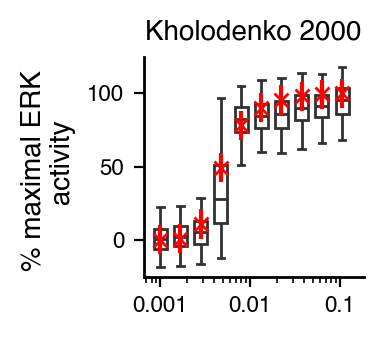

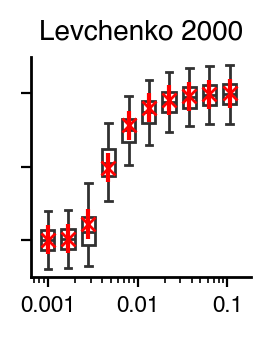

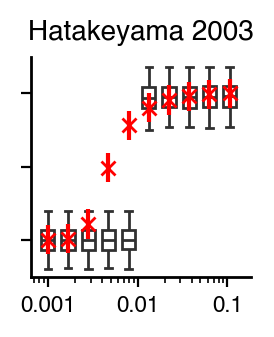

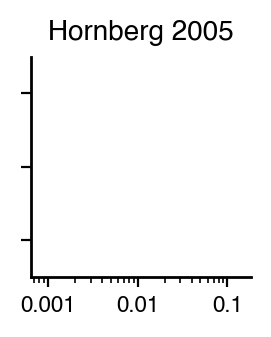

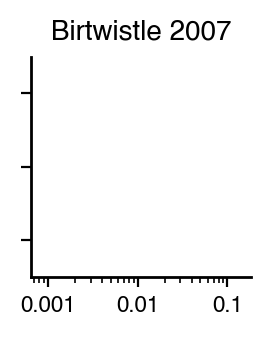

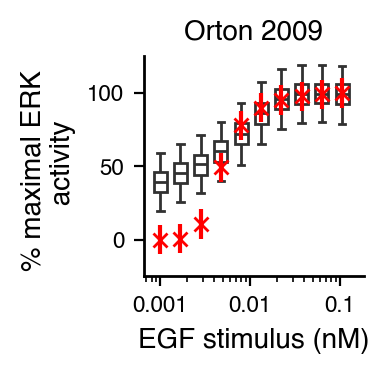

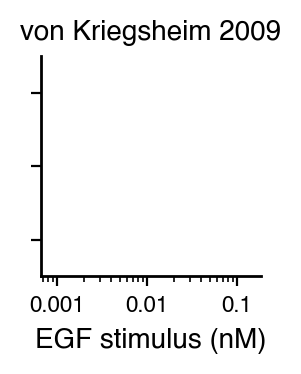

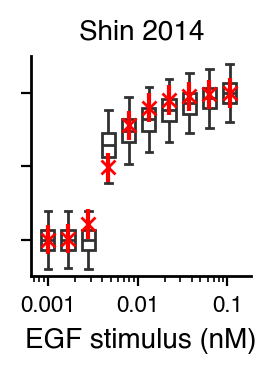

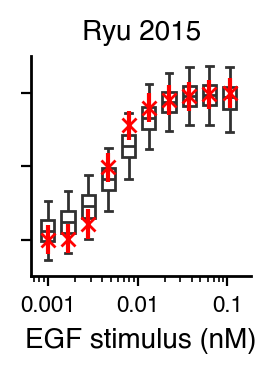

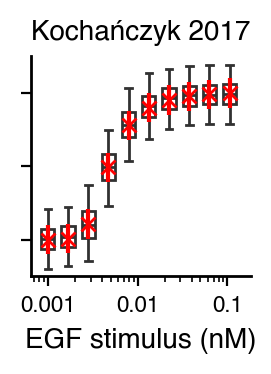

In [23]:
fig, ax = plot_stimulus_response_curve(K_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Kholodenko 2000', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/K_2000_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve(L_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Levchenko 2000', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/L_2000_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(HK_2003_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hatakeyama 2003', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/HK_2003_posterior_predictive.pdf', transparent=True)

# TODO: Hornberg 2005
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
ax.set_xlim([0.0006539278817108092, 0.18412936150507658])
ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hornberg 2005', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/H_2005_posterior_predictive.pdf', transparent=True)

# TODO: Birtwistle 2007
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_xlim([0.0006539278817108092, 0.18412936150507658])
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Birtwistle 2007', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/B_2007_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(O_2009_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Orton 2009', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/O_2009_posterior_predictive.pdf', transparent=True)

# TODO: von Kriegsheim 2009
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-2, 1e-1])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([0.0006539278817108092, 0.18412936150507658])
ax.set_ylabel('')
ax.set_title('von Kriegsheim 2009', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/VK_2009_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(S_2014_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Shin 2014', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/S_2014_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(R_2015_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Ryu 2015', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/R_2015_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(K_2017_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Kochańczyk 2017', fontsize=10.0)
fig.savefig('../../../results/MAPK/param_est/K_2017_posterior_predictive.pdf', transparent=True)